# Paper 1: Regularization Effectiveness Study
## Autoren: Katrin Nguyen & Nico Loss

## Import & Setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import warnings
import pickle

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, lasso_path, enet_path, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import ConvergenceWarning

from scipy.stats import ttest_rel

# Suppress convergence warnings for cleaner output
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Matplotlib inline for Jupyter Notebooks
%matplotlib inline

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Global variables
CV_FOLDS = 5
ALPHA_RANGE = np.logspace(-4, 1, 30)
MAX_ITER = 10000
CV_SCORING = "r2"

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Create output directories
output_dirs = ['ReportsV2', 'ModelsV2', 'SaveV2', 'DataV2']
for dir_name in output_dirs:
    Path(dir_name).mkdir(exist_ok=True)

D:\Master KDT\Semester 1\Angew KI\WorkspaceKDT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data Loading & Initial Exploration
Download Dataset from Kaggle.com: https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices/data

In [2]:
# Download dataset
path = kagglehub.dataset_download("nancyalaswad90/diamonds-prices")
print(f"Dataset path: {path}")

# Load data
df_raw = pd.read_csv(path + "/Diamonds Prices2022.csv")

# Remove erroneous index column if present
if "Unnamed: 0" in df_raw.columns:
    df_raw.drop(columns=["Unnamed: 0"], inplace=True)

print(f"\nDataset shape: {df_raw.shape}")
print(f"Features: {df_raw.shape[1]}")
print(f"Samples: {df_raw.shape[0]:,}")

# Basic information
print("\nDataset Info:")
print(df_raw.info())

print("\nFirst 5 rows:")
display(df_raw.head())

print("\nStatistical Summary:")
display(df_raw.describe())

# Check for missing values
missing_values = df_raw.isnull().sum()
if missing_values.any():
    print("\nMissing Values:")
    print(missing_values[missing_values > 0])
else:
    print("\n✓ No missing values detected")

Dataset path: C:\Users\nicol\.cache\kagglehub\datasets\nancyalaswad90\diamonds-prices\versions\4

Dataset shape: (53943, 10)
Features: 10
Samples: 53,943

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53943 non-null  float64
 1   cut      53943 non-null  object 
 2   color    53943 non-null  object 
 3   clarity  53943 non-null  object 
 4   depth    53943 non-null  float64
 5   table    53943 non-null  float64
 6   price    53943 non-null  int64  
 7   x        53943 non-null  float64
 8   y        53943 non-null  float64
 9   z        53943 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None

First 5 rows:


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75



Statistical Summary:


,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000



✓ No missing values detected


## 3. Comprehensive Data Preprocessing

In [3]:
class DiamondPreprocessor:
    """
    Comprehensive preprocessing pipeline for diamond data.
    Handles outliers, missing values, feature engineering, and encoding.
    """

    def __init__(self, outlier_method='iqr', outlier_threshold=3.0):
        self.outlier_method = outlier_method
        self.outlier_threshold = outlier_threshold
        self.encodings = None
        self.outlier_bounds = {}
        self.preprocessing_stats = {}

    def fit(self, df):
        """Fit preprocessing parameters on training data"""
        # Store ordinal encodings based on domain knowledge
        self.encodings = {
            'cut': {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5},
            'color': {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7},
            'clarity': {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4,
                       'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
        }

        # Calculate outlier bounds for numerical features
        numerical_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
        for col in numerical_cols:
            if self.outlier_method == 'iqr':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                self.outlier_bounds[col] = {
                    'lower': Q1 - self.outlier_threshold * IQR,
                    'upper': Q3 + self.outlier_threshold * IQR
                }
            elif self.outlier_method == 'zscore':
                mean = df[col].mean()
                std = df[col].std()
                self.outlier_bounds[col] = {
                    'lower': mean - self.outlier_threshold * std,
                    'upper': mean + self.outlier_threshold * std
                }

        return self

    def transform(self, df):
        """Apply preprocessing transformations"""
        df_clean = df.copy()
        initial_size = len(df_clean)

        # Track preprocessing steps
        steps_log = []

        # Step 1: Remove invalid dimensions
        invalid_dims = (df_clean['x'] <= 0) | (df_clean['y'] <= 0) | (df_clean['z'] <= 0)
        n_invalid = invalid_dims.sum()
        df_clean = df_clean[~invalid_dims]
        steps_log.append(f"Removed {n_invalid} rows with invalid dimensions")

        # Step 2: Handle outliers
        for col, bounds in self.outlier_bounds.items():
            outliers = (df_clean[col] < bounds['lower']) | (df_clean[col] > bounds['upper'])
            n_outliers = outliers.sum()
            df_clean = df_clean[~outliers]
            steps_log.append(f"Removed {n_outliers} outliers from {col}")

        # Step 3: Ordinal encoding for categorical variables
        for col, mapping in self.encodings.items():
            df_clean[f'{col}_encoded'] = df_clean[col].map(mapping)

            # Handle unknown categories
            n_unknown = df_clean[f'{col}_encoded'].isna().sum()
            if n_unknown > 0:
                # Use median imputation for unknown categories
                median_val = df_clean[f'{col}_encoded'].median()
                df_clean[f'{col}_encoded'].fillna(median_val, inplace=True)
                steps_log.append(f"Imputed {n_unknown} unknown {col} values with median")

        # Step 4: Feature Engineering
        # Volume-based features
        df_clean['volume'] = df_clean['x'] * df_clean['y'] * df_clean['z']
        df_clean['surface_area'] = 2 * (df_clean['x']*df_clean['y'] +
                                        df_clean['y']*df_clean['z'] +
                                        df_clean['x']*df_clean['z'])

        # Ratio features
        df_clean['xy_ratio'] = df_clean['x'] / df_clean['y']
        df_clean['xz_ratio'] = df_clean['x'] / df_clean['z']
        df_clean['depth_table_ratio'] = df_clean['depth'] / df_clean['table']

        # Polynomial features
        df_clean['carat_squared'] = df_clean['carat'] ** 2
        df_clean['carat_cubed'] = df_clean['carat'] ** 3

        # Interaction features
        df_clean['carat_cut_interaction'] = df_clean['carat'] * df_clean['cut_encoded']
        df_clean['volume_clarity_interaction'] = df_clean['volume'] * df_clean['clarity_encoded']

        # Quality index (composite feature)
        df_clean['quality_index'] = (df_clean['cut_encoded'] +
                                     df_clean['color_encoded'] +
                                     df_clean['clarity_encoded']) / 3

        steps_log.append("Added 11 engineered features")

        # Step 5: Drop original categorical columns
        df_clean = df_clean.drop(columns=['cut', 'color', 'clarity'])

        # Log preprocessing summary
        final_size = len(df_clean)
        print("\nPreprocessing Summary:")
        for step in steps_log:
            print(f"  • {step}")
        print(f"\nRows: {initial_size:,} → {final_size:,} ({final_size/initial_size*100:.1f}% retained)")
        print(f"Features: {df.shape[1]} → {df_clean.shape[1]}")

        return df_clean

    def fit_transform(self, df):
        """Fit and transform in one step"""
        return self.fit(df).transform(df)

### 3.1 Train-Validation-Test Split Strategy

In [4]:
# Split strategy: 60% train, 20% validation, 20% test
# Stratify by price quartiles to ensure price distribution consistency

# Create price quartiles for stratification
price_quartiles = pd.qcut(df_raw['price'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# First split: separate test set
X_temp = df_raw.drop('price', axis=1)
y_temp = np.log(df_raw['price'])

X_train_val, X_test_raw, y_train_val, y_test_raw, strat_train_val, strat_test = train_test_split(
    X_temp, y_temp, price_quartiles,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=price_quartiles
)

# Second split: separate train and validation
strat_train_val_reset = pd.Series(strat_train_val.values)
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,  # 0.25 of 0.80 = 0.20 of total
    random_state=RANDOM_SEED,
    stratify=strat_train_val_reset
)

print(f"Split Sizes:")
print(f"  • Training:   {len(X_train_raw):,} samples ({len(X_train_raw)/len(df_raw)*100:.1f}%)")
print(f"  • Validation: {len(X_val_raw):,} samples ({len(X_val_raw)/len(df_raw)*100:.1f}%)")
print(f"  • Test:       {len(X_test_raw):,} samples ({len(X_test_raw)/len(df_raw)*100:.1f}%)")

# Verify price distribution consistency
print("\nPrice Distribution Check:")
print(f"  • Train mean: ${y_train_raw.mean():,.2f} (std: ${y_train_raw.std():,.2f})")
print(f"  • Val mean:   ${y_val_raw.mean():,.2f} (std: ${y_val_raw.std():,.2f})")
print(f"  • Test mean:  ${y_test_raw.mean():,.2f} (std: ${y_test_raw.std():,.2f})")

# Combine X and y for preprocessing
train_df = pd.concat([X_train_raw, y_train_raw], axis=1)
val_df = pd.concat([X_val_raw, y_val_raw], axis=1)
test_df = pd.concat([X_test_raw, y_test_raw], axis=1)

Split Sizes:
  • Training:   32,365 samples (60.0%)
  • Validation: 10,789 samples (20.0%)
  • Test:       10,789 samples (20.0%)

Price Distribution Check:
  • Train mean: $7.79 (std: $1.01)
  • Val mean:   $7.79 (std: $1.01)
  • Test mean:  $7.79 (std: $1.02)


### 3.2 Apply Preprocessing Pipeline

In [5]:
# Initialize preprocessor
preprocessor = DiamondPreprocessor(outlier_method='iqr', outlier_threshold=3.0)

# Fit on training data and transform all sets
print("\n1. Processing Training Data:")
train_processed = preprocessor.fit_transform(train_df)

print("\n2. Processing Validation Data:")
val_processed = preprocessor.transform(val_df)

print("\n3. Processing Test Data:")
test_processed = preprocessor.transform(test_df)

# Separate features and target
y_train = train_processed['price']
X_train = train_processed.drop('price', axis=1)

y_val = val_processed['price']
X_val = val_processed.drop('price', axis=1)

y_test = test_processed['price']
X_test = test_processed.drop('price', axis=1)

print(f"\nFinal Dataset Shapes:")
print(f"  • X_train: {X_train.shape}")
print(f"  • X_val:   {X_val.shape}")
print(f"  • X_test:  {X_test.shape}")


1. Processing Training Data:

Preprocessing Summary:
  • Removed 13 rows with invalid dimensions
  • Removed 27 outliers from carat
  • Removed 166 outliers from depth
  • Removed 11 outliers from table
  • Removed 0 outliers from x
  • Removed 1 outliers from y
  • Removed 1 outliers from z
  • Added 11 engineered features

Rows: 32,365 → 32,146 (99.3% retained)
Features: 10 → 20

2. Processing Validation Data:

Preprocessing Summary:
  • Removed 5 rows with invalid dimensions
  • Removed 6 outliers from carat
  • Removed 57 outliers from depth
  • Removed 4 outliers from table
  • Removed 0 outliers from x
  • Removed 0 outliers from y
  • Removed 0 outliers from z
  • Added 11 engineered features

Rows: 10,789 → 10,717 (99.3% retained)
Features: 10 → 20

3. Processing Test Data:

Preprocessing Summary:
  • Removed 2 rows with invalid dimensions
  • Removed 7 outliers from carat
  • Removed 52 outliers from depth
  • Removed 4 outliers from table
  • Removed 0 outliers from x
  • Re

### 3.3 Feature Scaling/Normalization

In [6]:
feature_cols = X_train.columns.tolist()

# Use RobustScaler for better handling of outliers
scaler = RobustScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for feature tracking
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Scaling Statistics (from training data):")
scaling_stats = pd.DataFrame({
    'Median': scaler.center_,
    'IQR': scaler.scale_
}, index=X_train.columns)
print(scaling_stats.head(10))

# Save preprocessed data and scaler
print("\nSaving preprocessed data and transformers...")
pickle.dump(preprocessor, open('ModelsV2/preprocessor.pkl', 'wb'))
pickle.dump(scaler, open('ModelsV2/scaler.pkl', 'wb'))

# Save processed datasets
X_train_scaled.to_csv('DataV2/X_train_scaled.csv', index=False)
X_val_scaled.to_csv('DataV2/X_val_scaled.csv', index=False)
X_test_scaled.to_csv('DataV2/X_test_scaled.csv', index=False)
y_train.to_csv('DataV2/y_train.csv', index=False)
y_val.to_csv('DataV2/y_val.csv', index=False)
y_test.to_csv('DataV2/y_test.csv', index=False)

print("✓ Preprocessing complete!")

Scaling Statistics (from training data):
                     Median        IQR
carat              0.700000    0.64000
depth             61.800000    1.40000
table             57.000000    3.00000
x                  5.690000    1.83000
y                  5.710000    1.82000
z                  3.530000    1.12000
cut_encoded        4.000000    2.00000
color_encoded      4.000000    3.00000
clarity_encoded    4.000000    2.00000
volume           114.686269  106.01925

Saving preprocessed data and transformers...
✓ Preprocessing complete!


## Baseline-Model

In [7]:
print("\n" + "="*50)
print("BASELINE MODEL (LinearRegression) - ORDINARY LEAST SQUARES")
print("="*50)

# Train baseline model
baseline = LinearRegression()
baseline.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_baseline = baseline.predict(X_train_scaled)
y_val_pred_baseline = baseline.predict(X_val_scaled)
y_test_pred_baseline = baseline.predict(X_test_scaled)

# Evaluate baseline
baseline_metrics = {
    'Train R²': r2_score(np.exp(y_train), np.exp(y_train_pred_baseline)),
    'Val R²': r2_score(np.exp(y_val), np.exp(y_val_pred_baseline)),
    'Test R²': r2_score(np.exp(y_test), np.exp(y_test_pred_baseline)),

    'Train RMSE': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred_baseline))),
    'Val RMSE': np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_val_pred_baseline))),
    'Test RMSE': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred_baseline))),

    'Train MAE': mean_absolute_error(np.exp(y_train), np.exp(y_train_pred_baseline)),
    'Val MAE': mean_absolute_error(np.exp(y_val), np.exp(y_val_pred_baseline)),
    'Test MAE': mean_absolute_error(np.exp(y_test), np.exp(y_test_pred_baseline))
}

print("Baseline Performance:")
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

train_test_gap = baseline_metrics['Train R²'] - baseline_metrics['Test R²']
print(f"\nTrain-Test R² Gap: {train_test_gap:.4f}")
if train_test_gap > 0.05:
    print("  → Indication of overfitting")


BASELINE MODEL (LinearRegression) - ORDINARY LEAST SQUARES
Baseline Performance:
  Train R²: 0.9419
  Val R²: 0.9567
  Test R²: 0.9570
  Train RMSE: 955.1485
  Val RMSE: 829.4284
  Test RMSE: 834.8015
  Train MAE: 426.1610
  Val MAE: 421.0315
  Test MAE: 423.4709

Train-Test R² Gap: -0.0151


## Ridge Regression

In [8]:
print("\n" + "="*50)
print("RIDGE REGRESSION (L2 REGULARIZATION)")
print("="*50)

# Hyperparameter tuning with cross-validation
alphas_ridge = ALPHA_RANGE
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=CV_FOLDS, scoring=CV_SCORING)
ridge_cv.fit(X_train_scaled, y_train)

print(f"Optimal alpha: {ridge_cv.alpha_:.6f}")

# Train final Ridge model
ridge_best = Ridge(alpha=ridge_cv.alpha_)
ridge_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_ridge = ridge_best.predict(X_train_scaled)
y_val_pred_ridge = ridge_best.predict(X_val_scaled)
y_test_pred_ridge = ridge_best.predict(X_test_scaled)

# Evaluate Ridge
ridge_metrics = {
    'Train R²': r2_score(np.exp(y_train), np.exp(y_train_pred_ridge)),
    'Val R²': r2_score(np.exp(y_val), np.exp(y_val_pred_ridge)),
    'Test R²': r2_score(np.exp(y_test), np.exp(y_test_pred_ridge)),

    'Train RMSE': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred_ridge))),
    'Val RMSE': np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_val_pred_ridge))),
    'Test RMSE': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred_ridge))),

    'Train MAE': mean_absolute_error(np.exp(y_train), np.exp(y_train_pred_ridge)),
    'Val MAE': mean_absolute_error(np.exp(y_val), np.exp(y_val_pred_ridge)),
    'Test MAE': mean_absolute_error(np.exp(y_test), np.exp(y_test_pred_ridge))
}

print("\nRidge Performance:")
for metric, value in ridge_metrics.items():
    print(f"  {metric}: {value:.4f}")


RIDGE REGRESSION (L2 REGULARIZATION)
Optimal alpha: 0.085317

Ridge Performance:
  Train R²: 0.9484
  Val R²: 0.9570
  Test R²: 0.9582
  Train RMSE: 900.1281
  Val RMSE: 825.9969
  Test RMSE: 823.2060
  Train MAE: 424.6516
  Val MAE: 420.7992
  Test MAE: 422.0976


## Lasso Regression

In [9]:
print("\n" + "="*50)
print("LASSO REGRESSION (L1 REGULARIZATION)")
print("="*50)

# Hyperparameter tuning with cross-validation
alphas_lasso = ALPHA_RANGE
lasso_cv = LassoCV(alphas=alphas_lasso, cv=CV_FOLDS, max_iter=MAX_ITER, random_state=42, n_jobs=-1)
lasso_cv.fit(X_train_scaled, y_train)

print(f"Optimal alpha: {lasso_cv.alpha_:.6f}")

# Train final Lasso model
lasso_best = Lasso(alpha=lasso_cv.alpha_, max_iter=MAX_ITER)
lasso_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lasso = lasso_best.predict(X_train_scaled)
y_val_pred_lasso = lasso_best.predict(X_val_scaled)
y_test_pred_lasso = lasso_best.predict(X_test_scaled)

# Evaluate Lasso
lasso_metrics = {
    'Train R²': r2_score(np.exp(y_train), np.exp(y_train_pred_lasso)),
    'Val R²': r2_score(np.exp(y_val), np.exp(y_val_pred_lasso)),
    'Test R²': r2_score(np.exp(y_test), np.exp(y_test_pred_lasso)),

    'Train RMSE': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred_lasso))),
    'Val RMSE': np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_val_pred_lasso))),
    'Test RMSE': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred_lasso))),

    'Train MAE': mean_absolute_error(np.exp(y_train), np.exp(y_train_pred_lasso)),
    'Val MAE': mean_absolute_error(np.exp(y_val), np.exp(y_val_pred_lasso)),
    'Test MAE': mean_absolute_error(np.exp(y_test), np.exp(y_test_pred_lasso))
}

print("\nLasso Performance:")
for metric, value in lasso_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Feature selection analysis
n_features_selected = np.sum(lasso_best.coef_ != 0)
print(f"\nFeatures selected by Lasso: {n_features_selected}/{len(feature_cols)}")
print("Selected features:")
for i, (feature, coef) in enumerate(zip(feature_cols, lasso_best.coef_)):
    if coef != 0:
        print(f"  {feature}: {coef:.4f}")


LASSO REGRESSION (L1 REGULARIZATION)
Optimal alpha: 0.000100

Lasso Performance:
  Train R²: 0.9560
  Val R²: 0.9570
  Test R²: 0.9601
  Train RMSE: 830.8469
  Val RMSE: 826.2233
  Test RMSE: 804.8304
  Train MAE: 432.1695
  Val MAE: 432.0600
  Test MAE: 426.4981

Features selected by Lasso: 16/19
Selected features:
  carat: 1.4040
  depth: 0.0669
  table: -0.0684
  x: -0.0557
  y: 1.5288
  z: 0.1214
  color_encoded: 0.1480
  clarity_encoded: 0.1462
  volume: -0.5208
  xy_ratio: 0.0510
  xz_ratio: -0.0045
  depth_table_ratio: -0.0907
  carat_squared: -0.7940
  carat_cubed: 0.1347
  volume_clarity_interaction: 0.0529
  quality_index: 0.1141


## Elastic Net

In [10]:
print("\n" + "="*50)
print("ELASTIC NET (L1 + L2 REGULARIZATION)")
print("="*50)

# Hyperparameter tuning with cross-validation
alphas_elastic = ALPHA_RANGE
l1_ratios = np.arange(0.1, 1.0, 0.1)
elastic_cv = ElasticNetCV(
    alphas=alphas_elastic,
    l1_ratio=l1_ratios,
    cv=CV_FOLDS,
    max_iter=MAX_ITER,
    random_state=42,
    n_jobs=-1
)
elastic_cv.fit(X_train_scaled, y_train)

print(f"Optimal alpha: {elastic_cv.alpha_:.6f}")
print(f"Optimal l1_ratio: {elastic_cv.l1_ratio_:.2f}")

# Train final ElasticNet model
elastic_best = ElasticNet(
    alpha=elastic_cv.alpha_,
    l1_ratio=elastic_cv.l1_ratio_,
    max_iter=MAX_ITER
)
elastic_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_elastic = elastic_best.predict(X_train_scaled)
y_val_pred_elastic = elastic_best.predict(X_val_scaled)
y_test_pred_elastic = elastic_best.predict(X_test_scaled)

# Evaluate ElasticNet
elastic_metrics = {
    'Train R²': r2_score(np.exp(y_train), np.exp(y_train_pred_elastic)),
    'Val R²': r2_score(np.exp(y_val), np.exp(y_val_pred_elastic)),
    'Test R²': r2_score(np.exp(y_test), np.exp(y_test_pred_elastic)),

    'Train RMSE': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred_elastic))),
    'Val RMSE': np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_val_pred_elastic))),
    'Test RMSE': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred_elastic))),

    'Train MAE': mean_absolute_error(np.exp(y_train), np.exp(y_train_pred_elastic)),
    'Val MAE': mean_absolute_error(np.exp(y_val), np.exp(y_val_pred_elastic)),
    'Test MAE': mean_absolute_error(np.exp(y_test), np.exp(y_test_pred_elastic))
}

print("\nElasticNet Performance:")
for metric, value in elastic_metrics.items():
    print(f"  {metric}: {value:.4f}")


ELASTIC NET (L1 + L2 REGULARIZATION)
Optimal alpha: 0.000100
Optimal l1_ratio: 0.10

ElasticNet Performance:
  Train R²: 0.9561
  Val R²: 0.9569
  Test R²: 0.9599
  Train RMSE: 830.2643
  Val RMSE: 827.2323
  Test RMSE: 806.6076
  Train MAE: 431.6315
  Val MAE: 431.7653
  Test MAE: 427.0183


## Model Comparison

In [11]:
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

# Create comparison dataframe
comparison_data = {
    'OLS': baseline_metrics,
    'Ridge': ridge_metrics,
    'Lasso': lasso_metrics,
    'ElasticNet': elastic_metrics
}

comparison_df = pd.DataFrame(comparison_data).T
print("Performance Comparison Table:")
print(comparison_df.round(4))

# Calculate improvements over baseline
print("\nImprovement over OLS (Test R²):")
for model in ['Ridge', 'Lasso', 'ElasticNet']:
    improvement = comparison_df.loc[model, 'Test R²'] - comparison_df.loc['OLS', 'Test R²']
    pct_improvement = (improvement / comparison_df.loc['OLS', 'Test R²']) * 100
    print(f"  {model}: {improvement:.4f} ({pct_improvement:.2f}%)")

# Train-Test Gap Analysis
print("\nTrain-Test R² Gap (Overfitting Analysis):")
for model in comparison_df.index:
    gap = comparison_df.loc[model, 'Train R²'] - comparison_df.loc[model, 'Test R²']
    print(f"  {model}: {gap:.4f}")


MODEL COMPARISON
Performance Comparison Table:
            Train R²  Val R²  Test R²  Train RMSE  Val RMSE  Test RMSE  \
OLS           0.9419  0.9567   0.9570    955.1485  829.4284   834.8015   
Ridge         0.9484  0.9570   0.9582    900.1281  825.9969   823.2060   
Lasso         0.9560  0.9570   0.9601    830.8469  826.2233   804.8304   
ElasticNet    0.9561  0.9569   0.9599    830.2643  827.2323   806.6076   

            Train MAE   Val MAE  Test MAE  
OLS          426.1610  421.0315  423.4709  
Ridge        424.6516  420.7992  422.0976  
Lasso        432.1695  432.0600  426.4981  
ElasticNet   431.6315  431.7653  427.0183  

Improvement over OLS (Test R²):
  Ridge: 0.0012 (0.12%)
  Lasso: 0.0030 (0.32%)
  ElasticNet: 0.0029 (0.30%)

Train-Test R² Gap (Overfitting Analysis):
  OLS: -0.0151
  Ridge: -0.0098
  Lasso: -0.0040
  ElasticNet: -0.0038



VISUALIZING MODEL COEFFICIENTS


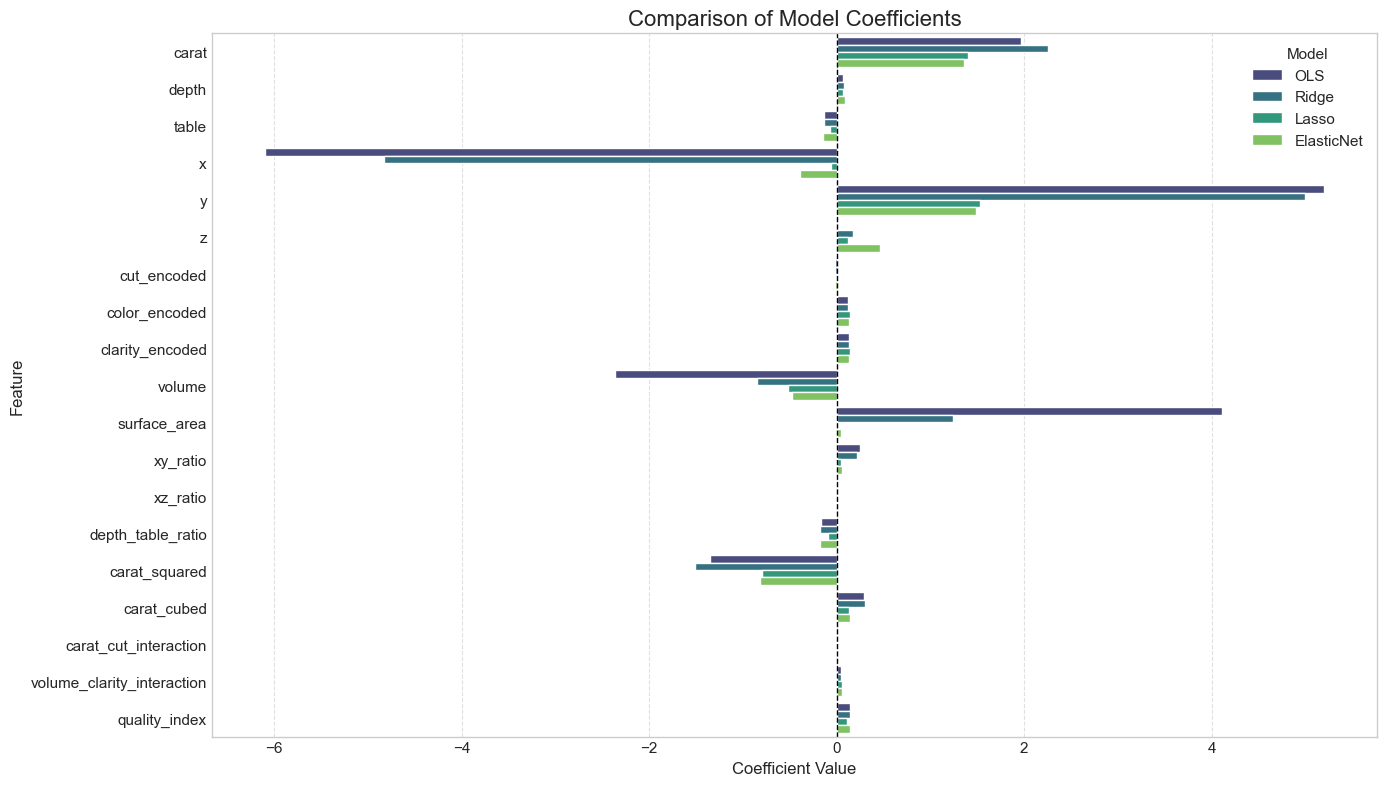

Coefficient comparison plot generated!


In [12]:
print("\n" + "="*50)
print("VISUALIZING MODEL COEFFICIENTS")
print("="*50)

# Create a DataFrame with the coefficients
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'OLS': baseline.coef_,
    'Ridge': ridge_best.coef_,
    'Lasso': lasso_best.coef_,
    'ElasticNet': elastic_best.coef_
})

# Melt the DataFrame for easy plotting with seaborn
coef_df_melted = coef_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x='Coefficient', y='Feature', hue='Model', data=coef_df_melted, palette='viridis')
plt.title('Comparison of Model Coefficients', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend(title='Model')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('SaveV2/coefficient_comparison.png', dpi=300)
plt.show()

print("Coefficient comparison plot generated!")

## Visualizations


GENERATING VISUALIZATIONS


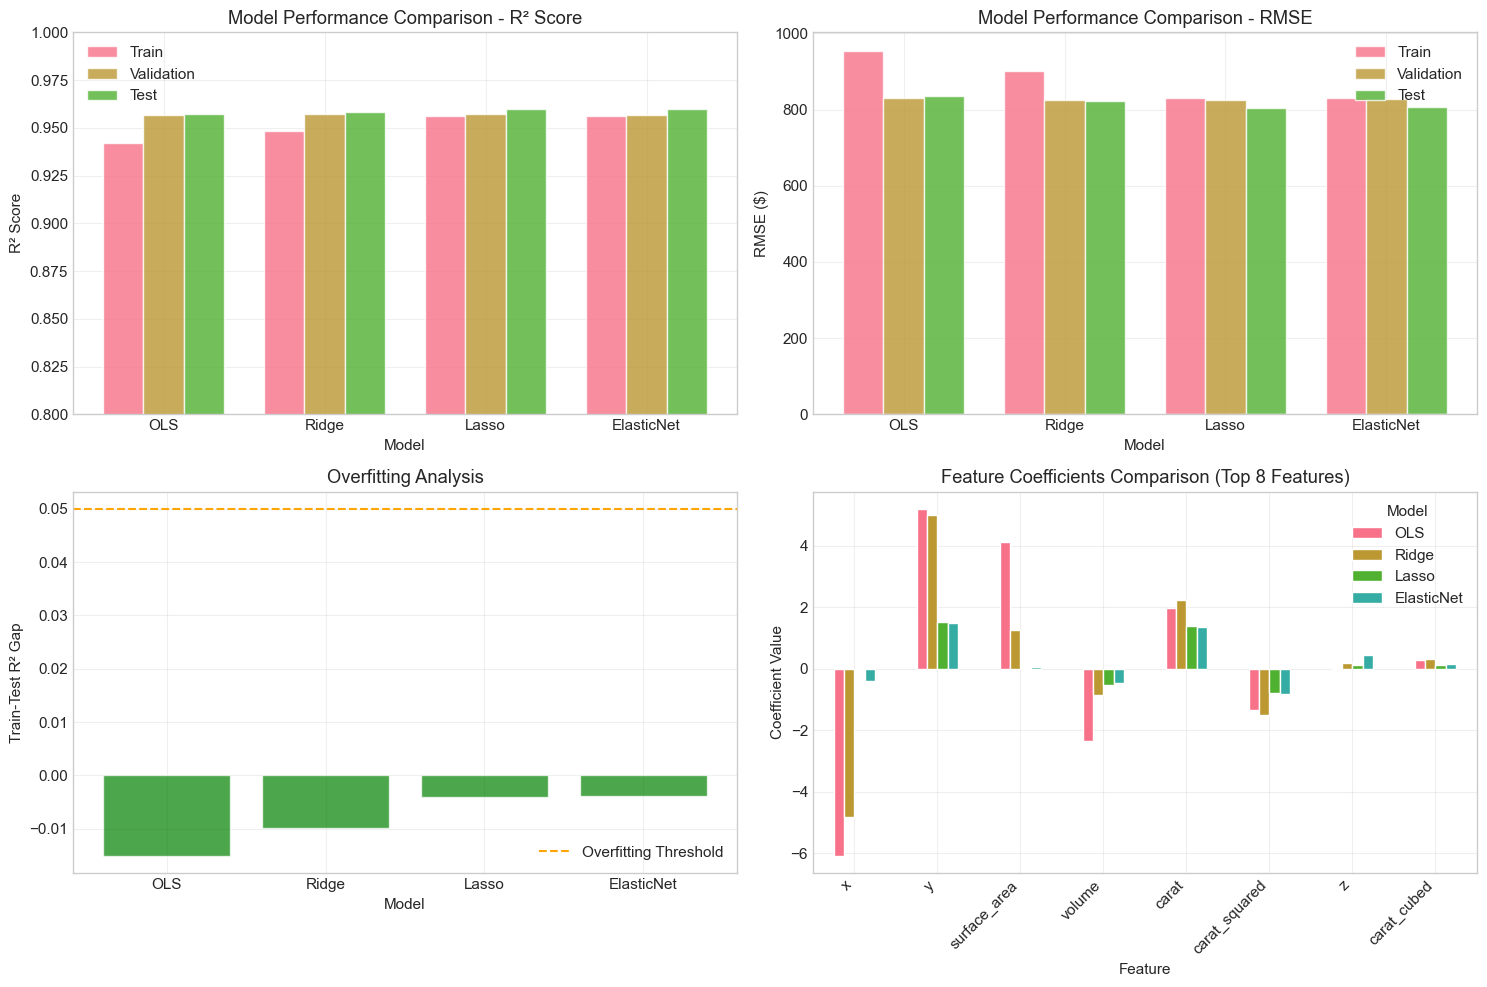

In [13]:
print("\n" + "="*50)
print("GENERATING VISUALIZATIONS")
print("="*50)

# 1. Model Comparison Bar Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# R² Comparison
ax1 = axes[0, 0]
models = ['OLS', 'Ridge', 'Lasso', 'ElasticNet']
train_r2 = [comparison_df.loc[m, 'Train R²'] for m in models]
val_r2 = [comparison_df.loc[m, 'Val R²'] for m in models]
test_r2 = [comparison_df.loc[m, 'Test R²'] for m in models]

x = np.arange(len(models))
width = 0.25

ax1.bar(x - width, train_r2, width, label='Train', alpha=0.8)
ax1.bar(x, val_r2, width, label='Validation', alpha=0.8)
ax1.bar(x + width, test_r2, width, label='Test', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Performance Comparison - R² Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_ylim([0.8, 1.0])  # Angepasster Bereich für bessere Sichtbarkeit
ax1.grid(True, alpha=0.3)

# RMSE Comparison
ax2 = axes[0, 1]
train_rmse = [comparison_df.loc[m, 'Train RMSE'] for m in models]
val_rmse = [comparison_df.loc[m, 'Val RMSE'] for m in models]
test_rmse = [comparison_df.loc[m, 'Test RMSE'] for m in models]

ax2.bar(x - width, train_rmse, width, label='Train', alpha=0.8)
ax2.bar(x, val_rmse, width, label='Validation', alpha=0.8)
ax2.bar(x + width, test_rmse, width, label='Test', alpha=0.8)
ax2.set_xlabel('Model')
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Model Performance Comparison - RMSE')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Train-Test Gap
ax3 = axes[1, 0]
gaps = [comparison_df.loc[m, 'Train R²'] - comparison_df.loc[m, 'Test R²'] for m in models]
colors = ['red' if g > 0.05 else 'green' for g in gaps]
ax3.bar(models, gaps, color=colors, alpha=0.7)
ax3.axhline(y=0.05, color='orange', linestyle='--', label='Overfitting Threshold')
ax3.set_xlabel('Model')
ax3.set_ylabel('Train-Test R² Gap')
ax3.set_title('Overfitting Analysis')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Feature Coefficients
ax4 = axes[1, 1]
coef_data = pd.DataFrame({
    'OLS': baseline.coef_,
    'Ridge': ridge_best.coef_,
    'Lasso': lasso_best.coef_,
    'ElasticNet': elastic_best.coef_
}, index=feature_cols)

# Plot only most important features
important_features = coef_data.abs().max(axis=1).nlargest(8).index
coef_data.loc[important_features].plot(kind='bar', ax=ax4)
ax4.set_xlabel('Feature')
ax4.set_ylabel('Coefficient Value')
ax4.set_title('Feature Coefficients Comparison (Top 8 Features)')
ax4.legend(title='Model')
ax4.grid(True, alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('SaveV2/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Generating learning curves...


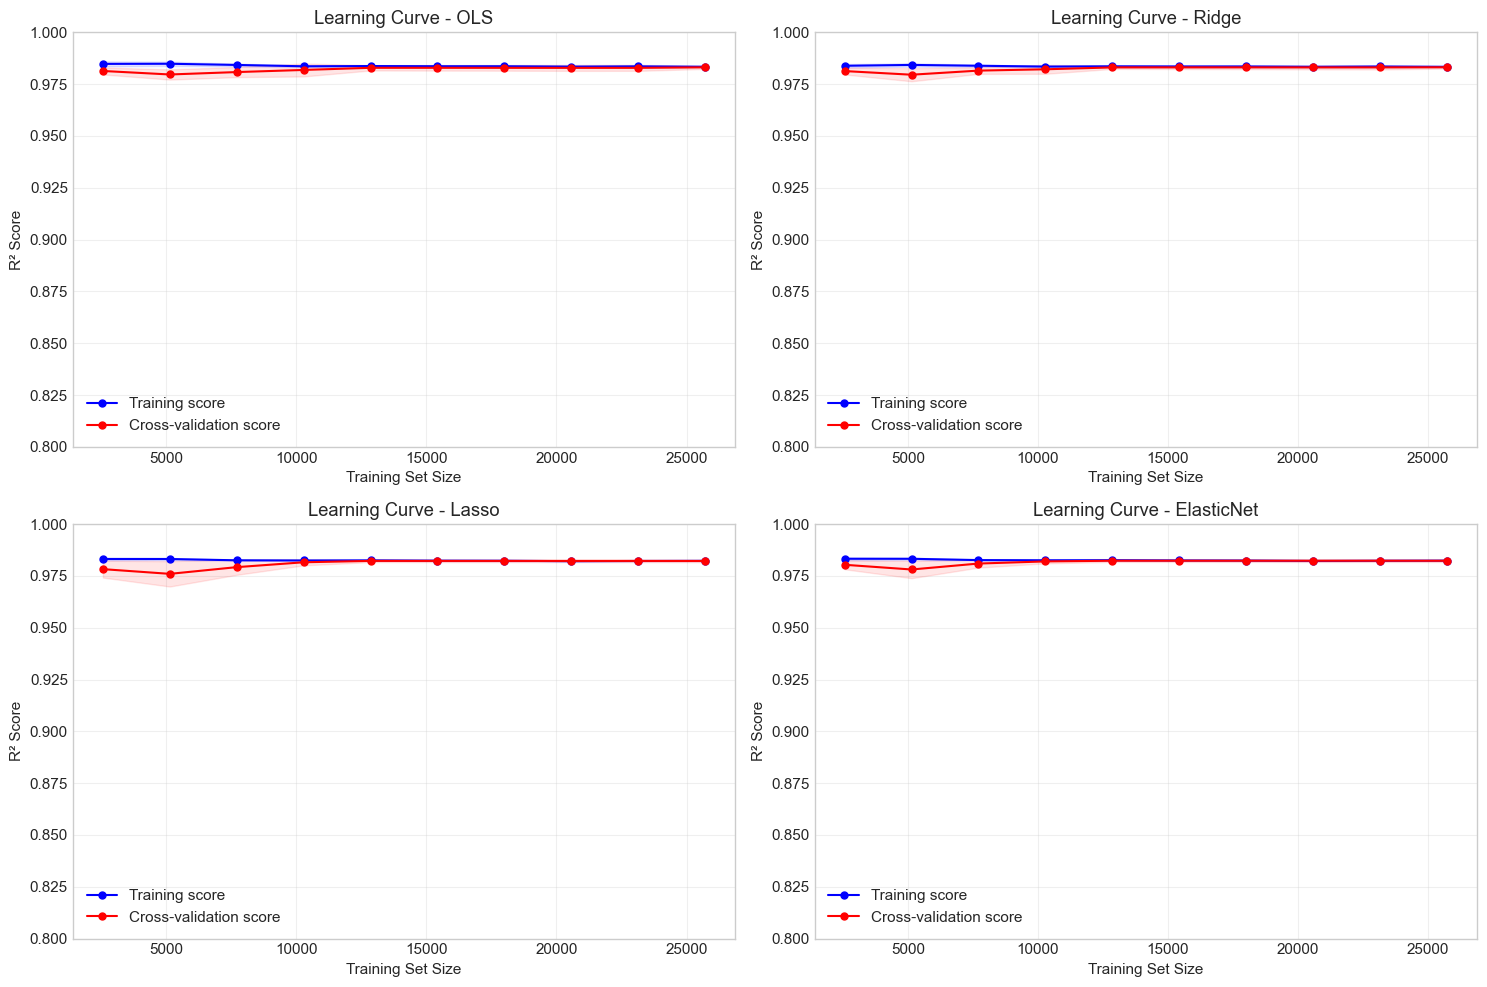

In [14]:
# 2. Learning Curves
print("\nGenerating learning curves...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models_dict = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(alpha=ridge_cv.alpha_),
    'Lasso': Lasso(alpha=lasso_cv.alpha_, max_iter=MAX_ITER),
    'ElasticNet': ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_, max_iter=MAX_ITER)
}

train_sizes = np.linspace(0.1, 1.0, 10)

for idx, (model_name, model) in enumerate(models_dict.items()):
    ax = axes[idx // 2, idx % 2]

    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train,
        train_sizes=train_sizes, cv=CV_FOLDS,
        scoring=CV_SCORING, n_jobs=-1, random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    ax.plot(train_sizes_abs, train_scores_mean, 'o-', color='blue',label='Training score', markersize=5)
    ax.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color='blue')

    ax.plot(train_sizes_abs, val_scores_mean, 'o-', color='red',label='Cross-validation score', markersize=5)
    ax.fill_between(train_sizes_abs, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='red')

    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('R² Score')
    ax.set_title(f'Learning Curve - {model_name}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.8, 1])  # Angepasster Bereich für bessere Sichtbarkeit

plt.tight_layout()
plt.savefig('SaveV2/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()


Generating regularization paths...
Computing Ridge path...
  Ridge: 0/30
  Ridge: 10/30
  Ridge: 20/30
Computing Lasso path...
Computing ElasticNet path...


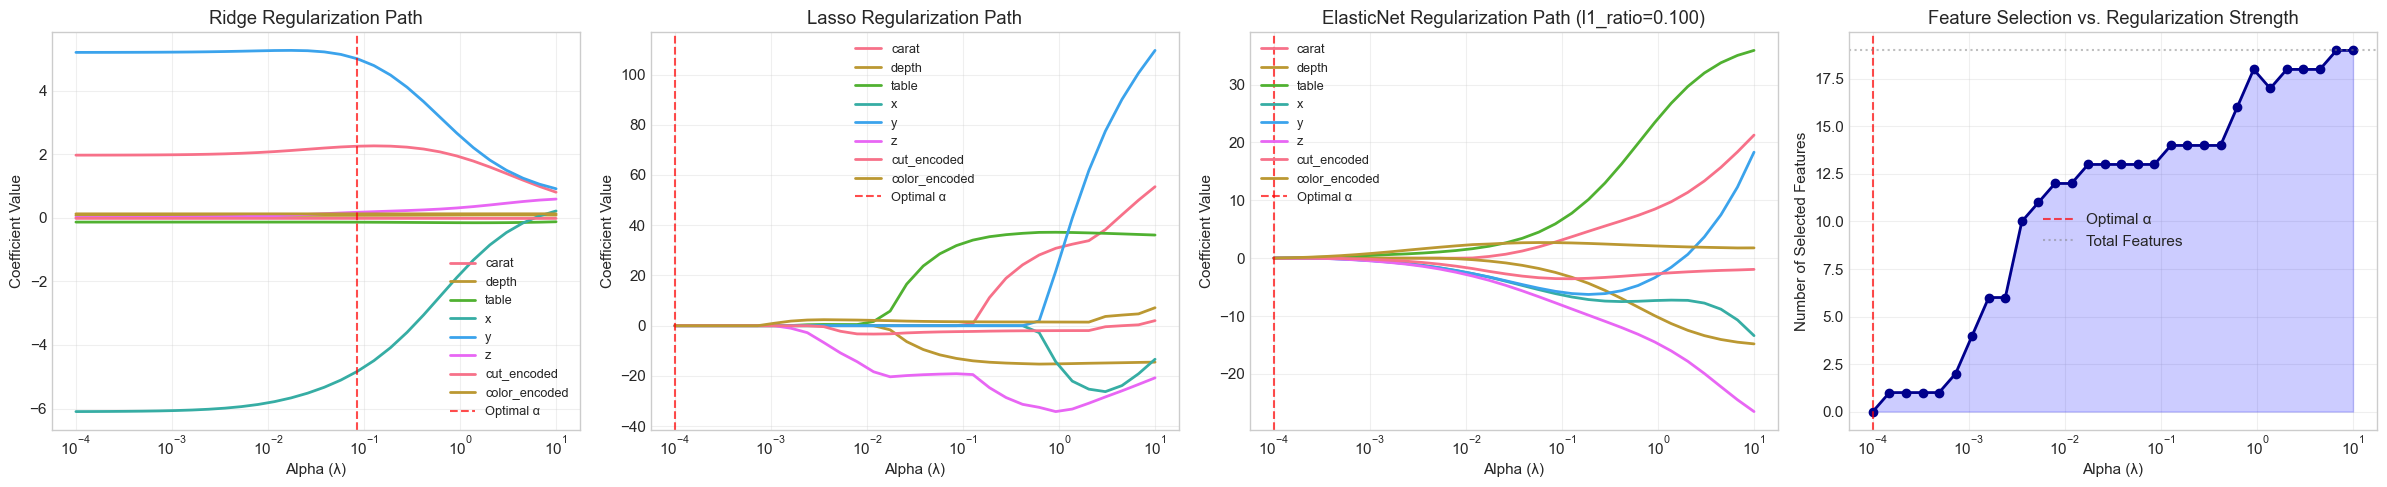

Regularization paths completed!


In [15]:
# 3. Regularization Paths
print("\nGenerating regularization paths...")
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# ===== RIDGE PATH =====
print("Computing Ridge path...")
alphas_path = ALPHA_RANGE
ridge_coefs = []

for i, alpha in enumerate(alphas_path):
    if i % 10 == 0:  # Progress indicator
        print(f"  Ridge: {i}/{len(alphas_path)}")
    ridge_temp = Ridge(alpha=alpha)
    ridge_temp.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge_temp.coef_)

ridge_coefs = np.array(ridge_coefs)

ax1 = axes[0]

for i, feature in enumerate(feature_cols[:8]):
    ax1.plot(alphas_path, ridge_coefs[:, i], label=feature, linewidth=2)
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (λ)')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Ridge Regularization Path')
ax1.axvline(x=ridge_cv.alpha_, color='red', linestyle='--', alpha=0.7, label='Optimal α')
ax1.legend(loc='best', fontsize='small')
ax1.grid(True, alpha=0.3)

# ===== LASSO PATH (mit Feature Count) =====
print("Computing Lasso path...")

_, lasso_coefs, _ = lasso_path(
    X_train_scaled, y_train, alphas=alphas_path, max_iter=MAX_ITER, tol=1e-3
)

lasso_coefs = lasso_coefs.T
# Anzahl der Features berechnen
n_features_selected = np.sum(np.abs(lasso_coefs) > 1e-5, axis=1)


ax2 = axes[1]
for i, feature in enumerate(feature_cols[:8]):
    ax2.plot(alphas_path, lasso_coefs[:, i], label=feature, linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (λ)')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Lasso Regularization Path')
ax2.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', alpha=0.7, label='Optimal α')
ax2.legend(loc='best', fontsize='small')
ax2.grid(True, alpha=0.3)

# ===== ELASTICNET PATH =====
print("Computing ElasticNet path...")

_, enet_coefs, _ = enet_path(
    X_train_scaled, y_train, alphas=alphas_path,
    l1_ratio=elastic_cv.l1_ratio_, max_iter=MAX_ITER, tol=1e-3
)
enet_coefs = enet_coefs.T

ax3 = axes[2]
for i, feature in enumerate(feature_cols[:8]):
    ax3.plot(alphas_path, enet_coefs[:, i], label=feature, linewidth=2)
ax3.set_xscale('log')
ax3.set_xlabel('Alpha (λ)')
ax3.set_ylabel('Coefficient Value')
ax3.set_title(f'ElasticNet Regularization Path (l1_ratio={elastic_cv.l1_ratio_:.3f})')
ax3.axvline(x=elastic_cv.alpha_, color='red', linestyle='--', alpha=0.7, label='Optimal α')
ax3.legend(loc='best', fontsize='small')
ax3.grid(True, alpha=0.3)

# ===== FEATURE SELECTION COUNT =====
ax3 = axes[3]
ax3.plot(alphas_path, n_features_selected, 'o-', markersize=6, linewidth=2, color='darkblue')
ax3.fill_between(alphas_path, 0, n_features_selected, alpha=0.2, color='blue')
ax3.set_xscale('log')
ax3.set_xlabel('Alpha (λ)')
ax3.set_ylabel('Number of Selected Features')
ax3.set_title('Feature Selection vs. Regularization Strength')
ax3.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', alpha=0.7, label='Optimal α')
ax3.axhline(y=len(feature_cols), color='gray', linestyle=':', alpha=0.5, label='Total Features')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('SaveV2/regularization_paths.png', dpi=300, bbox_inches='tight')
plt.show()

print("Regularization paths completed!")


Generating cross-validation curves...
Computing Ridge CV scores...
  Ridge progress: 0/30
  Ridge progress: 5/30
  Ridge progress: 10/30
  Ridge progress: 15/30
  Ridge progress: 20/30
  Ridge progress: 25/30
Computing Lasso CV scores...
  Lasso progress: 0/30
  Lasso progress: 5/30
  Lasso progress: 10/30
  Lasso progress: 15/30
  Lasso progress: 20/30
  Lasso progress: 25/30
Computing ElasticNet CV scores...
  ElasticNet progress: 0/30
  ElasticNet progress: 5/30
  ElasticNet progress: 10/30
  ElasticNet progress: 15/30
  ElasticNet progress: 20/30
  ElasticNet progress: 25/30


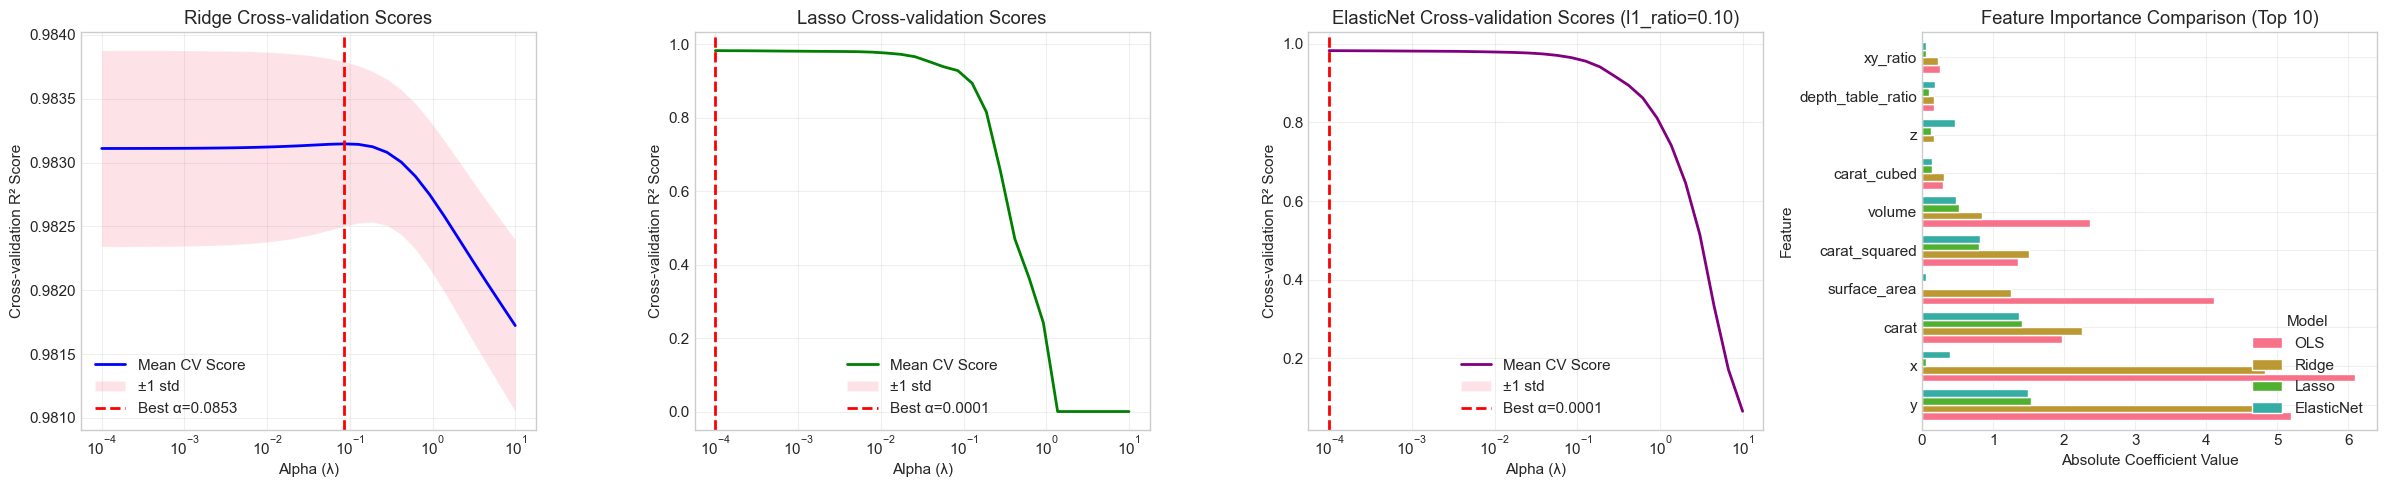

Cross-validation analysis completed!


In [16]:
# 4. Cross-validation curves
print("\nGenerating cross-validation curves...")
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# ===== RIDGE CV =====
print("Computing Ridge CV scores...")
ax1 = axes[0]

alphas_ridge_cv = ALPHA_RANGE
ridge_scores_mean = []
ridge_scores_std = []

for i, alpha in enumerate(alphas_ridge_cv):
    if i % 5 == 0:
        print(f"  Ridge progress: {i}/{len(alphas_ridge_cv)}")
    ridge_temp = Ridge(alpha=alpha)
    scores = cross_val_score(ridge_temp,
                             X_train_scaled,
                             y_train,
                             cv=CV_FOLDS, scoring=CV_SCORING, n_jobs=-1)
    ridge_scores_mean.append(scores.mean())
    ridge_scores_std.append(scores.std())

ridge_scores_mean = np.array(ridge_scores_mean)
ridge_scores_std = np.array(ridge_scores_std)

ax1.plot(alphas_ridge_cv, ridge_scores_mean, 'b-', linewidth=2, label='Mean CV Score')
ax1.fill_between(alphas_ridge_cv,
                  ridge_scores_mean - ridge_scores_std,
                  ridge_scores_mean + ridge_scores_std,
                  alpha=0.2, label='±1 std')
ax1.axvline(x=ridge_cv.alpha_, color='red', linestyle='--', linewidth=2, label=f'Best α={ridge_cv.alpha_:.4f}')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (λ)')
ax1.set_ylabel('Cross-validation R² Score')
ax1.set_title('Ridge Cross-validation Scores')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ===== LASSO CV =====
print("Computing Lasso CV scores...")
ax2 = axes[1]

alphas_lasso_cv = ALPHA_RANGE
lasso_scores_mean = []
lasso_scores_std = []

for i, alpha in enumerate(alphas_lasso_cv):
    if i % 5 == 0:
        print(f"  Lasso progress: {i}/{len(alphas_lasso_cv)}")
    lasso_temp = Lasso(alpha=alpha, max_iter=MAX_ITER, tol=1e-3)
    scores = cross_val_score(lasso_temp, X_train_scaled, y_train, cv=CV_FOLDS, scoring=CV_SCORING, n_jobs=-1)
    lasso_scores_mean.append(scores.mean())
    lasso_scores_std.append(scores.std())

lasso_scores_mean = np.array(lasso_scores_mean)
lasso_scores_std = np.array(lasso_scores_std)

ax2.plot(alphas_lasso_cv, lasso_scores_mean, 'g-', linewidth=2, label='Mean CV Score')
ax2.fill_between(alphas_lasso_cv,
                  lasso_scores_mean - lasso_scores_std,
                  lasso_scores_mean + lasso_scores_std,
                  alpha=0.2, label='±1 std')
ax2.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', linewidth=2, label=f'Best α={lasso_cv.alpha_:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (λ)')
ax2.set_ylabel('Cross-validation R² Score')
ax2.set_title('Lasso Cross-validation Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ===== ELASTICNET CV =====
print("Computing ElasticNet CV scores...")
ax3 = axes[2]

alphas_elastic_cv = ALPHA_RANGE
elastic_scores_mean = []
elastic_scores_std = []

for i, alpha in enumerate(alphas_elastic_cv):
    if i % 5 == 0:
        print(f"  ElasticNet progress: {i}/{len(alphas_elastic_cv)}")
    elastic_temp = ElasticNet(alpha=alpha,
                              l1_ratio=elastic_cv.l1_ratio_,
                              max_iter=MAX_ITER,
                              tol=1e-3)
    scores = cross_val_score(elastic_temp, X_train_scaled, y_train, cv=CV_FOLDS, scoring=CV_SCORING, n_jobs=-1)
    elastic_scores_mean.append(scores.mean())
    elastic_scores_std.append(scores.std())

elastic_scores_mean = np.array(elastic_scores_mean)
elastic_scores_std = np.array(elastic_scores_std)

ax3.plot(alphas_elastic_cv, elastic_scores_mean, 'purple', linewidth=2, label='Mean CV Score')
ax3.fill_between(alphas_elastic_cv,
                  elastic_scores_mean - elastic_scores_std,
                  elastic_scores_mean + elastic_scores_std,
                  alpha=0.2, label='±1 std')
ax3.axvline(x=elastic_cv.alpha_, color='red', linestyle='--', linewidth=2,
            label=f'Best α={elastic_cv.alpha_:.4f}')
ax3.set_xscale('log')
ax3.set_xlabel('Alpha (λ)')
ax3.set_ylabel('Cross-validation R² Score')
ax3.set_title(f'ElasticNet Cross-validation Scores (l1_ratio={elastic_cv.l1_ratio_:.2f})')
ax3.legend()
ax3.grid(True, alpha=0.3)

# ===== FEATURE IMPORTANCE =====
ax3 = axes[3]
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'OLS': np.abs(baseline.coef_),
    'Ridge': np.abs(ridge_best.coef_),
    'Lasso': np.abs(lasso_best.coef_),
    'ElasticNet': np.abs(elastic_best.coef_)
})

# Berechne durchschnittliche Wichtigkeit
feature_importance_mean = feature_importance[['OLS', 'Ridge', 'Lasso', 'ElasticNet']].mean(axis=1)
feature_importance['Mean'] = feature_importance_mean
feature_importance_sorted = feature_importance.nlargest(10, 'Mean')

# Erstelle Barplot
feature_importance_sorted.set_index('Feature')[['OLS', 'Ridge', 'Lasso', 'ElasticNet']].plot(
    kind='barh', ax=ax3, width=0.8
)
ax3.set_xlabel('Absolute Coefficient Value')
ax3.set_title('Feature Importance Comparison (Top 10)')
ax3.legend(title='Model', loc='lower right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('SaveV2/cv_curves_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Cross-validation analysis completed!")

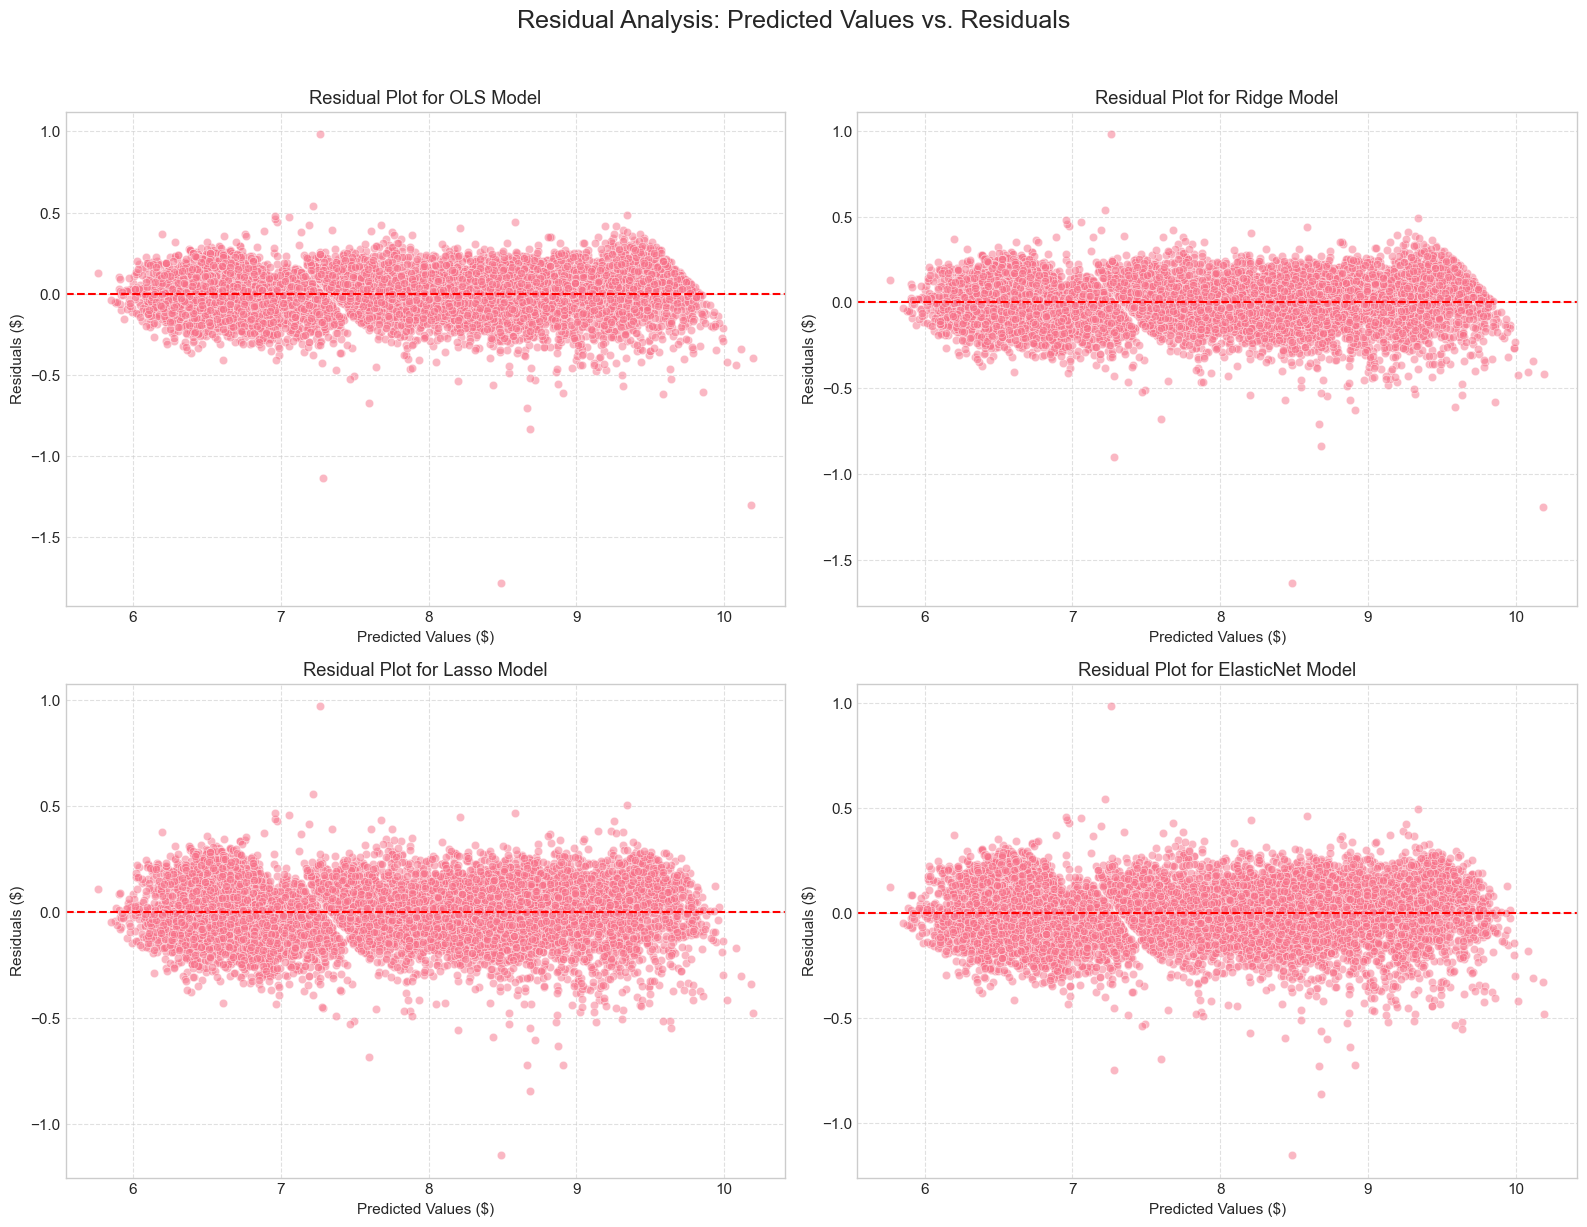

Residual analysis plots generated!


In [17]:
# Calculate residuals for the test set for all models
residuals = {
    'OLS': y_test - y_test_pred_baseline,
    'Ridge': y_test - y_test_pred_ridge,
    'Lasso': y_test - y_test_pred_lasso,
    'ElasticNet': y_test - y_test_pred_elastic
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (model_name, resid) in enumerate(residuals.items()):
    ax = axes[i]
    # Scatter plot of predictions vs. residuals
    sns.scatterplot(x=y_test_pred_baseline, y=resid, ax=ax, alpha=0.5)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_xlabel('Predicted Values ($)')
    ax.set_ylabel('Residuals ($)')
    ax.set_title(f'Residual Plot for {model_name} Model')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Residual Analysis: Predicted Values vs. Residuals', fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig('SaveV2/residual_plots.png', dpi=300)
plt.show()

print("Residual analysis plots generated!")

## Statistical Significance Testing

In [18]:
print("\n" + "="*50)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Perform cross-validation for all models to get multiple scores
print(f"Performing {CV_FOLDS}-fold cross-validation for statistical testing...")

cv_scores = {}
for model_name, model in models_dict.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=CV_FOLDS, scoring=CV_SCORING, n_jobs=-1)
    cv_scores[model_name] = scores
    print(f"{model_name}: Mean R² = {scores.mean():.4f} ± {scores.std():.4f}")

# Paired t-tests comparing each regularized model to OLS
print("\nPaired t-tests (comparing to OLS baseline):")
for model_name in ['Ridge', 'Lasso', 'ElasticNet']:
    t_stat, p_value = ttest_rel(cv_scores[model_name], cv_scores['OLS'])
    print(f"\n{model_name} vs OLS:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.6f}")
    if p_value < 0.05:
        if t_stat > 0:
            print(f"  → {model_name} is significantly better than OLS (p < 0.05)")
        else:
            print(f"  → OLS is significantly better than {model_name} (p < 0.05)")
    else:
        print(f"  → No significant difference between {model_name} and OLS (p ≥ 0.05)")


STATISTICAL SIGNIFICANCE TESTING
Performing 5-fold cross-validation for statistical testing...
OLS: Mean R² = 0.9831 ± 0.0008
Ridge: Mean R² = 0.9831 ± 0.0006
Lasso: Mean R² = 0.9822 ± 0.0006
ElasticNet: Mean R² = 0.9823 ± 0.0006

Paired t-tests (comparing to OLS baseline):

Ridge vs OLS:
  t-statistic: 0.3677
  p-value: 0.731729
  → No significant difference between Ridge and OLS (p ≥ 0.05)

Lasso vs OLS:
  t-statistic: -2.6476
  p-value: 0.057124
  → No significant difference between Lasso and OLS (p ≥ 0.05)

ElasticNet vs OLS:
  t-statistic: -2.3814
  p-value: 0.075878
  → No significant difference between ElasticNet and OLS (p ≥ 0.05)


## Result Summary

In [19]:
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)

# Best model selection
test_r2_scores = {
    'OLS': comparison_df.loc['OLS', 'Test R²'],
    'Ridge': comparison_df.loc['Ridge', 'Test R²'],
    'Lasso': comparison_df.loc['Lasso', 'Test R²'],
    'ElasticNet': comparison_df.loc['ElasticNet', 'Test R²']
}

best_model = max(test_r2_scores, key=test_r2_scores.get)
best_score = test_r2_scores[best_model]

print(f"\nBest Model: {best_model}")
print(f"Test R² Score: {best_score:.4f}")

# Answer to research question
print("\n" + "="*50)
print("ANSWER TO RESEARCH QUESTION")
print("="*50)
print("\nDoes regularization materially improve generalization on the diamonds dataset?")
print("-" * 70)

improvement_ridge = test_r2_scores['Ridge'] - test_r2_scores['OLS']
improvement_lasso = test_r2_scores['Lasso'] - test_r2_scores['OLS']
improvement_elastic = test_r2_scores['ElasticNet'] - test_r2_scores['OLS']

if max(improvement_ridge, improvement_lasso, improvement_elastic) > 0.01:
    print("YES - Regularization provides meaningful improvement:")
    print(f"  • Ridge improvement: {improvement_ridge:.4f} ({improvement_ridge/test_r2_scores['OLS']*100:.2f}%)")
    print(f"  • Lasso improvement: {improvement_lasso:.4f} ({improvement_lasso/test_r2_scores['OLS']*100:.2f}%)")
    print(f"  • ElasticNet improvement: {improvement_elastic:.4f} ({improvement_elastic/test_r2_scores['OLS']*100:.2f}%)")
else:
    print("NO - Regularization does not provide substantial improvement")
    print("  The improvements are marginal and may not justify the added complexity")

# Save results to CSV
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Save model comparison table
comparison_df.to_csv('SaveV2/model_comparison_results.csv')
print("Model comparison saved to 'model_comparison_results.csv'")

# Save feature importance
feature_importance.to_csv('SaveV2/feature_importance.csv', index=False)
print("Feature importance saved to 'feature_importance.csv'")

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)


FINAL RESULTS SUMMARY

Best Model: Lasso
Test R² Score: 0.9601

ANSWER TO RESEARCH QUESTION

Does regularization materially improve generalization on the diamonds dataset?
----------------------------------------------------------------------
NO - Regularization does not provide substantial improvement
  The improvements are marginal and may not justify the added complexity

SAVING RESULTS
Model comparison saved to 'model_comparison_results.csv'
Feature importance saved to 'feature_importance.csv'

ANALYSIS COMPLETE!
